# Finding outliers with standard deviation and regression

To reproduce this finding from the Dallas Morning News, we'll need to use standard deviation and regression to identify schools that performed suspiciously well in certain standardized tests.

<p class="reading-options">
  <a class="btn" href="/dmn-texas-school-cheating/texas-school-cheating-finding-outliers-with-standard-deviation-and-regression">
    <i class="fa fa-sm fa-book"></i>
    Read online
  </a>
  <a class="btn" href="/dmn-texas-school-cheating/notebooks/Texas School Cheating - Finding outliers with standard deviation and regression.ipynb">
    <i class="fa fa-sm fa-download"></i>
    Download notebook
  </a>
  <a class="btn" href="https://colab.research.google.com/github/littlecolumns/ds4j-notebooks/blob/master/dmn-texas-school-cheating/notebooks/Texas School Cheating - Finding outliers with standard deviation and regression.ipynb" target="_new">
    <i class="fa fa-sm fa-laptop"></i>
    Interactive version
  </a>
</p>

### Prep work: Downloading necessary files
Before we get started, we need to download all of the data we'll be using.
* **cfy04e4.dat:** 2004 fourth-grade TAKS scores - standardized test scores for 2004's fourth-graders
* **cfy03e3.dat:** 2003 third-grade TAKS scores - standardized test scores for 2003's third-graders
* **cfy04e5.dat:** 2004 fifth-grade TAKS scores - standardized test scores for 2004's fifth-graders
* **cfy04e3.dat:** 2004 third-grade TAKS scores - standardized test scores for 2004's third-graders


In [ ]:
# !brew install wget

In [1]:
# Make data directory if it doesn't exist
!mkdir -p data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/dmn-texas-school-cheating/data/cfy04e4.dat -P data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/dmn-texas-school-cheating/data/cfy03e3.dat -P data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/dmn-texas-school-cheating/data/cfy04e5.dat -P data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/dmn-texas-school-cheating/data/cfy04e3.dat -P data

--2022-02-22 15:47:06--  https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/dmn-texas-school-cheating/data/cfy04e4.dat
Resolving nyc3.digitaloceanspaces.com (nyc3.digitaloceanspaces.com)... 162.243.189.2
Connecting to nyc3.digitaloceanspaces.com (nyc3.digitaloceanspaces.com)|162.243.189.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15699181 (15M) [application/octet-stream]
Saving to: ‘data/cfy04e4.dat’

cfy04e4.dat         100%[===================>]  14.97M  4.60MB/s    in 3.3s    

2022-02-22 15:47:09 (4.60 MB/s) - ‘data/cfy04e4.dat’ saved [15699181/15699181]

--2022-02-22 15:47:10--  https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/dmn-texas-school-cheating/data/cfy03e3.dat
Resolving nyc3.digitaloceanspaces.com (nyc3.digitaloceanspaces.com)... 162.243.189.2
Connecting to nyc3.digitaloceanspaces.com (nyc3.digitaloceanspaces.com)|162.243.189.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11669172 (11M) [application/oc

## Finding suspicious behavior by tracking down outliers

In [2]:
import pandas as pd
import numpy as np

from plotnine import *

import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)

# Reading in our data

We'll start by opening up our dataset - standardized test performance at each school, for fourth graders in 2004.

In [3]:
df = pd.read_csv("data/cfy04e4.dat", usecols=['r_all_rs', 'CNAME', 'CAMPUS'])
df = df.set_index('CAMPUS').add_suffix('_fourth')
df.head()

,CNAME_fourth,r_all_rs_fourth
CAMPUS,,
1902103,CAYUGA EL,2392.0
1903101,ELKHART EL,2263.0
1904102,FRANKSTON EL,2242.0
1906102,NECHES EL,2218.0
1907110,STORY EL,2200.0


That dataset had a lot of columns, but we're only interested in their **reading scores**.

How can we find out who did **suspiciously well?** We should problably start with figuring out which schools performed **normally.** Statistically speaking, "normal performance" is probably the median (one of the three types of averages).

In [4]:
df.r_all_rs_fourth.median()

2226.0

The median is the 50% mark of the score: half of the schools did better than 2226, and half of the schools did worse.

As a school's score gets further and further from the median, the school is going further and further from being an "average school." If a schools get a lot lot lot of points, it should probably be looked at. **But how many extra points is enough to make the school suspicious?**

In [5]:
df.r_all_rs_fourth.describe()

count    3706.000000
mean     2227.245008
std        68.598894
min      1951.000000
25%      2181.000000
50%      2226.000000
75%      2273.000000
max      2509.000000
Name: r_all_rs_fourth, dtype: float64

If 2226 points is the average, 2273 puts a school at the 75% mark. 75% still doesn't seem very suspicious, though, as that's still one out of every four schools. We want something higher! 95%? 99.7%?

/usr/local/lib/python3.9/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_bin : Removed 74 rows containing non-finite values.


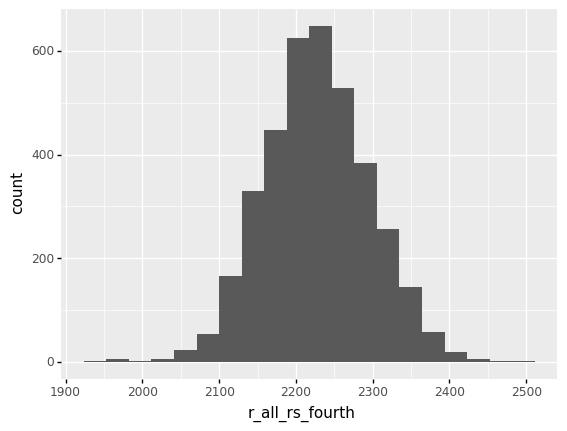

<ggplot: (312731688)>

In [6]:
(
    ggplot(df, aes(x='r_all_rs_fourth')) 
        + geom_histogram(bins=20)
)

We want those very few datapoints on the far right! 

Instead of picking an arbitrary number or percentile, we're going to start using a statistical measure called the **standard deviation**. It's a measurement of how spread out the data is (`std` in the list above). To explain how unusual a data point is, you can say "it's 1.5 standard deviations from the mean" or "2.75 standard deviations from the mean."

In [7]:
df['std_dev_rs_fourth'] = (df.r_all_rs_fourth - df.r_all_rs_fourth.mean()) / df.r_all_rs_fourth.std()
df.head()

,CNAME_fourth,r_all_rs_fourth,std_dev_rs_fourth
CAMPUS,,,
1902103,CAYUGA EL,2392.0,2.401715
1903101,ELKHART EL,2263.0,0.521218
1904102,FRANKSTON EL,2242.0,0.215091
1906102,NECHES EL,2218.0,-0.134769
1907110,STORY EL,2200.0,-0.397164


Now every school has a new column that explains how many standard deviations away from the average score it is. We can asily look at the top and bottom performers!

In [8]:
df.sort_values(by='std_dev_rs_fourth').head(20)

,CNAME_fourth,r_all_rs_fourth,std_dev_rs_fourth
CAMPUS,,,
167903001,STAR SCHOOL,1951.0,-4.026960
101912386,DIVERSITY ROOTS,1958.0,-3.924918
101912140,DOGAN EL,1972.0,-3.720833
101912114,BRAEBURN EL,1972.0,-3.720833
57817101,FOCUS LEARNING,1973.0,-3.706255
15819001,SHEKINAH RADIAN,1976.0,-3.662523
57830002,INSPIRED VISION,1979.0,-3.618790
18903001,MORGAN SCHOOL,1999.0,-3.327240
101912129,CLINTON PARK EL,2005.0,-3.239775


In [9]:
df.sort_values(by='std_dev_rs_fourth', ascending=False).head(20)

,CNAME_fourth,r_all_rs_fourth,std_dev_rs_fourth
CAMPUS,,,
131001103,SARITA EL,2509.0,4.107282
101912296,T H ROGERS EL,2480.0,3.684535
57905115,HARRELL BUDD EL,2470.0,3.538760
180901101,MIMI FARLEY ELE,2448.0,3.218055
68901118,EL MAGNET AT RE,2432.0,2.984815
57909122,WALNUT GLEN ACA,2430.0,2.955660
57916123,PRAIRIE CREEK E,2426.0,2.897350
57916128,BRENTFIELD EL,2425.0,2.882772
57911102,BRADFIELD ELEME,2425.0,2.882772


# But let's not get ahead of ourselves!

The thing is, though: **some schools are just going to be better**. Getting a good score doesn't mean a school is cheating, it just means, well, that they got a good score!

We **could** use this list of standard deviations to investigate each and every school that did well, seeing if it makes sense that they did so well. That'd be good reporting! But it might also be a waste of time, as there wasn't anything "unusual" about these schools, they just... did well.

Now we need to ask ourselves **when could a test score be suspicious?** The Dallas Morning News realized they could look at scores across years at the same school - we were looking at fourth graders just now, but how did those students perform when they were in third grade? Did they just do average, and now suddenly they're geniuses? Suspicious!

Since we were working with 2004's fourth grader data, we'll now combine it with 2003's third-grader data.

In [10]:
third_graders = pd.read_csv("data/cfy03e3.dat", usecols=['CAMPUS', 'r_all_rs'])
third_graders = third_graders.set_index('CAMPUS').add_suffix('_third')
merged = df.join(third_graders)
merged.head()

,CNAME_fourth,r_all_rs_fourth,std_dev_rs_fourth,r_all_rs_third
CAMPUS,,,,
1902103,CAYUGA EL,2392.0,2.401715,2330.0
1903101,ELKHART EL,2263.0,0.521218,2285.0
1904102,FRANKSTON EL,2242.0,0.215091,2299.0
1906102,NECHES EL,2218.0,-0.134769,2236.0
1907110,STORY EL,2200.0,-0.397164,2202.0


# Graphing for research

One of the things we could do is plot the third grade scores as compared to the fourth grade scores, and see if anything stands out.

In [11]:
merged.query("CNAME_fourth=='HARRELL BUDD EL'")

,CNAME_fourth,r_all_rs_fourth,std_dev_rs_fourth,r_all_rs_third
CAMPUS,,,,
57905115,HARRELL BUDD EL,2470.0,3.53876,2140.0


/usr/local/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 279 rows containing missing values.


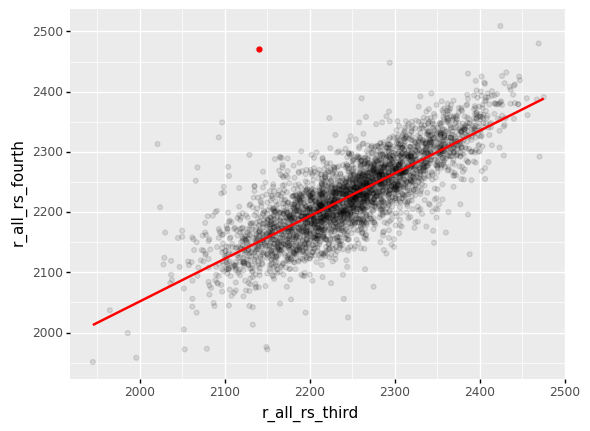

<ggplot: (312859167)>

In [12]:
highlight = merged.query("CNAME_fourth=='HARRELL BUDD EL'")

(
    ggplot(merged, aes(x='r_all_rs_third', y='r_all_rs_fourth')) 
        + geom_point(alpha=.1)
        + geom_smooth(method='lm', se=False, color='red')
        + geom_point(data=highlight, color='red')
)

This is one of the graphics from the Dallas Morning News Piece, and we've highlighted one of the suspicious schools, Harrell Budd Elementary.

In [13]:
highlight

,CNAME_fourth,r_all_rs_fourth,std_dev_rs_fourth,r_all_rs_third
CAMPUS,,,,
57905115,HARRELL BUDD EL,2470.0,3.53876,2140.0


You'd expect a school to perform similarly between third and fourth grade, but somehow this one school jumped from about 2150 points to 2500 points in one year! Seems suspicious.

But **why is that suspicious?** It's because we don't expect a school to make a jump of 350 points in one year, going from average to a high performer.

But **what do we expect a school to do?** I'm not sure, but just like The Dallas Morning News we can surely ask statistics for help!

# Using a regression to predict fourth-grade scores

The Dallas Morning News decided to run a **regression**, which is a way of predicting how two different variables interact. In this case, we want to see the relationship between a **third grade score** and a **fourth grade score**.

First we'll need to get rid of missing data, because regressions hate hate hate missing data.

In [14]:
print("Before dropping missing data", merged.shape)
merged = merged.dropna()
print("After dropping missing data", merged.shape)

Before dropping missing data (3780, 4)
After dropping missing data (3501, 4)


And now we can ask what the relationship is between third-grade scores and fourth-grade scores.

In [15]:
import statsmodels.formula.api as smf

model = smf.ols("r_all_rs_fourth ~ r_all_rs_third", data=merged)

results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        r_all_rs_fourth   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                     6410.
Date:                Tue, 22 Feb 2022   Prob (F-statistic):               0.00
Time:                        15:55:54   Log-Likelihood:                -17961.
No. Observations:                3501   AIC:                         3.593e+04
Df Residuals:                    3499   BIC:                         3.594e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        632.6929     19.936     31.736      0.000     593.606     671.780
r_all_rs_third     0.7094      0.009     80.061      0.000       0.692       0.727
==============================================================================
Omnibus:                      263.054   Durbin-Watson:                   1.897
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1312.900
Skew:                           0.147   Prob(JB):                    8.08e-286
Kurtosis:                       5.986   Cond. No.                     6.49e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.49e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

What's this all mean? It doesn't matter! What matters is that **if we know what third-grade score a school got, we can predict its fourth-grade score.**

In [16]:
# What should these schools have gotten?
sample = pd.DataFrame({ 'r_all_rs_third': [2140, 2200, 2500] })
results.predict(sample)

0    2150.828391
1    2193.392939
2    2406.215677
dtype: float64

In [17]:
merged['predicted_fourth'] = results.predict()
merged.head()

/var/folders/4r/qbtxk1s968n5kqwsz68bgc4c0000gn/T/ipykernel_10423/3009260212.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,CNAME_fourth,r_all_rs_fourth,std_dev_rs_fourth,r_all_rs_third,predicted_fourth
CAMPUS,,,,,
1902103,CAYUGA EL,2392.0,2.401715,2330.0,2285.616126
1903101,ELKHART EL,2263.0,0.521218,2285.0,2253.692715
1904102,FRANKSTON EL,2242.0,0.215091,2299.0,2263.624443
1906102,NECHES EL,2218.0,-0.134769,2236.0,2218.931668
1907110,STORY EL,2200.0,-0.397164,2202.0,2194.811757


## Using standard deviations with regression error

Notice how there's a difference between the _actual_ fourth-grade score and the _predicted_ fourth-grade score. This is called the **error** or **residual**. The bigger the error, the bigger the difference between what was expected and what actually happened.

Remember how we were suspicious of that one school because it performed normally, but then performed really well? A school like that is going to have a really big error!

To calculate what a "big error" is, we're going to use our old friend **standard deviation.** Before we used standard deviation to see how far a schools' score was from the average score. This time we're going to use standard deviation to see how far the school's error is from the average error!

In [18]:
# Just trust me, this is how you do it
merged['error_std_dev'] = results.resid / np.sqrt(results.mse_resid)
merged.head()

/var/folders/4r/qbtxk1s968n5kqwsz68bgc4c0000gn/T/ipykernel_10423/4262114716.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,CNAME_fourth,r_all_rs_fourth,std_dev_rs_fourth,r_all_rs_third,predicted_fourth,error_std_dev
CAMPUS,,,,,,
1902103,CAYUGA EL,2392.0,2.401715,2330.0,2285.616126,2.600187
1903101,ELKHART EL,2263.0,0.521218,2285.0,2253.692715,0.227484
1904102,FRANKSTON EL,2242.0,0.215091,2299.0,2263.624443,-0.528535
1906102,NECHES EL,2218.0,-0.134769,2236.0,2218.931668,-0.022771
1907110,STORY EL,2200.0,-0.397164,2202.0,2194.811757,0.126809


The more standard deviations away from the mean a school's error is, the more suspicious its fourth-grade performance is.

In [19]:
merged.sort_values(by='error_std_dev', ascending=False).head(10)

,CNAME_fourth,r_all_rs_fourth,std_dev_rs_fourth,r_all_rs_third,predicted_fourth,error_std_dev
CAMPUS,,,,,,
57905115,HARRELL BUDD EL,2470.0,3.538760,2140.0,2150.828391,7.801048
123803101,TEKOA ACADEMY O,2313.0,1.250093,2021.0,2066.408705,6.027073
15803101,HIGGS/CARTER/KI,2349.0,1.774883,2097.0,2120.323799,5.589200
101912172,HENDERSON N EL,2324.0,1.410445,2093.0,2117.486162,5.047518
180901101,MIMI FARLEY ELE,2448.0,3.218055,2294.0,2260.077397,4.593119
57825001,PINNACLE SCHOOL,2274.0,0.681571,2068.0,2099.750934,4.258917
131001103,SARITA EL,2509.0,4.107282,2424.0,2352.300584,3.829976
101823101,CHILDREN FIRST,2252.0,0.360866,2066.0,2098.332116,3.755881
61911111,PRAIRIE VIEW EL,2389.0,2.357983,2261.0,2236.666896,3.723257


# Reproducing the story

From The Dallas Morning News:

> "In statistician's lingo, these schools had at least one average score that was more than three standard deviations away from what would be predicted based on their scores in other grades or on other tests

While we've been talking about schools with a **major increase** between the two years, we're also interested in schools with a **major drop**. That could indicate cheating in 2003 and a return to "real" testing in 2004.

Let's check out all of our suspicious schools according to the three standard deviations test they performed.

In [20]:
merged[merged.error_std_dev.abs() > 3]

,CNAME_fourth,r_all_rs_fourth,std_dev_rs_fourth,r_all_rs_third,predicted_fourth,error_std_dev
CAMPUS,,,,,,
15803101,HIGGS/CARTER/KI,2349.0,1.774883,2097.0,2120.323799,5.589200
15819001,SHEKINAH RADIAN,1976.0,-3.662523,2149.0,2157.213074,-4.429128
19901102,DEKALB EL,2356.0,1.876925,2223.0,2209.709349,3.575570
22004101,TERLINGUA EL,2055.0,-2.510901,2178.0,2177.785938,-3.001078
25904101,BLANKET EL,2082.0,-2.117308,2225.0,2211.128167,-3.156092
47905001,SIDNEY SCHOOL,2208.0,-0.280544,2024.0,2068.536933,3.408693
50901101,EVANT EL,2169.0,-0.849066,2345.0,2296.257263,-3.110365
57817101,FOCUS LEARNING,1973.0,-3.706255,2079.0,2107.554435,-3.288719
57825001,PINNACLE SCHOOL,2274.0,0.681571,2068.0,2099.750934,4.258917


But then they level things up a bit:

> Using a stricter standard - four standard deviations from predictions - 41 schools have suspect scores

In [21]:
merged[merged.error_std_dev.abs() > 4]

,CNAME_fourth,r_all_rs_fourth,std_dev_rs_fourth,r_all_rs_third,predicted_fourth,error_std_dev
CAMPUS,,,,,,
15803101,HIGGS/CARTER/KI,2349.0,1.774883,2097.0,2120.323799,5.589200
15819001,SHEKINAH RADIAN,1976.0,-3.662523,2149.0,2157.213074,-4.429128
57825001,PINNACLE SCHOOL,2274.0,0.681571,2068.0,2099.750934,4.258917
57905115,HARRELL BUDD EL,2470.0,3.538760,2140.0,2150.828391,7.801048
101840101,TWO DIMENSIONS,2076.0,-2.204773,2275.0,2246.598624,-4.169694
101912134,CRAWFORD EL,2056.0,-2.496323,2240.0,2221.769304,-4.051658
101912140,DOGAN EL,1972.0,-3.720833,2150.0,2157.922483,-4.544233
101912172,HENDERSON N EL,2324.0,1.410445,2093.0,2117.486162,5.047518
105802041,SAN MARCOS PREP,2025.0,-2.948225,2245.0,2225.316350,-4.896042


Our dataset isn't as thorough as theirs - we're only looking at one combination of tests - but it's the same idea.

# Finding other suspicious scores

We might assume a school that does well in reading probably also does well in math.

**What if they did well in one, but not the other?** While the school might just have a strong department in one particular field, such discripancies could be worth investigating.

Let's look at fifth graders' math and reading scores from 2004.

In [ ]:
df = pd.read_csv("data/cfy04e5.dat", usecols=['CAMPUS', 'CNAME', 'm_all_rs', 'r_all_rs'])
df = df.set_index('CAMPUS').add_suffix('_fifth')
df.head()

# Building the graphic

While it isn't necessary, reproducing the graphics is always fun.

In [ ]:
highlight = df.query("CNAME_fifth=='SANDERSON EL' and CAMPUS==101912236")

(
    ggplot(df, aes(x='r_all_rs_fifth', y='m_all_rs_fifth')) 
        + geom_point(alpha=.1)
        + geom_smooth(method='lm', se=False, color='red')
        + geom_point(data=highlight, color='red')
)

In [ ]:
highlight

# Running the regression

We can't be exactly sure of the relationship between math and reading scores - it's a lot of schools! - so we'll run a regression to figure out how the two scores typically interact.

In [ ]:
print("Before dropping missing data", df.shape)
df = df.dropna()
print("After dropping missing data", df.shape)

In [ ]:
import statsmodels.formula.api as smf

model = smf.ols("m_all_rs_fifth ~ r_all_rs_fifth", data=df)

results = model.fit()
results.summary()

And now, just like last time, we calculate how many standard deviations away the actual score was from the predicted score. Large number of standard deviations away means a school is worth a look!

In [ ]:
df['error_std_dev'] = results.resid / np.sqrt(results.mse_resid)

df[df.error_std_dev.abs() > 3].sort_values(by='error_std_dev', ascending=False)

Wow, look at that! Sanderson Elementary looks like they either have a **really** exceptional math program or something suspicious is going on.

# Review

First, we learned about using **standard deviation** as a measurement of how unusual a measurement in a data point might be. Data points that fall many standard deviations from the mean - either above or below - might be worth investigating as bad data or from other suspicious angles (cheating schools, in this case).

Then we learned how a **linear regression** can determine the relationship between two numbers. In this case, it was how third-grade scores relate to fourth-grade scores, and then how math and reading scores relate to one another. By using a regression, you can use one variable to predict what the other should be.

Finally, we used the **residual** or **error** from the regression to see how far off each prediction was. Just like we did with the original scores, we used standard deviation to find usually suspiciously large errors. Even though yes, our regression might not be perfect, times when it's _very_ wrong probably call for an investigation.

# Discussion points

* Why would this analysis be based on standard deviations away from the predicted value instead of just the predicted value?
* Standard deviation is how far away from the "average" a school is. Let's say you scored 3 standard deviations away from the average, but it was only a 5-point difference. What kind of situation could lead to that? Is it as important as being 3 standard deviations away but with a 50-point difference? 
* The Dallas Morning News specifically called out schools with scores "more than three standard deviations away from what would be predicted based on their scores in other grades or on other tests." Do you think they ignored schools that were 2.99 standard deviations away?
* Did _we_ ignore those schools? If we did, how could we be more cautious in the future?
* What are the pros and cons of selecting a cutoff like three standard deviations away from the predicted value? Note that [three standard deviations is a typical number in stats](https://stats.stackexchange.com/questions/311174/what-does-it-mean-when-three-standard-deviations-away-from-the-mean-i-land-ou)
* What's the difference between a school with predicted scores -3 standard deviations away as compared to +3 standard deviations away? Do we need to pay attention to both, or only one?
* What next steps should we take after we've calculated these findings?
* If a school did have a strong math department and a weak english department, they would definitely be predicted incorrectly. What happens to that school after being flagged by research like this?